# UNets in JAX

A simple implementation of a hierarchical convolutional neural network in JAX;
used to learn a solver to a 1d Poisson equation.

$$ \frac{d^2 u}{dx^2} = - f(x) \qquad u(x=0) = u(x=L) = 0$$

The Poisson equation (together with homogeneous Dirichlet boundary conditions)
maps a force field $f(x)$ to the displacement of thin string $u(x)$.

The UNet $f_\theta$ is trained to map $f(x) \mapsto u(x)$.

Original UNet schematic by Ronneberger et al. (2015) (our concrete
implementation deviates from this):

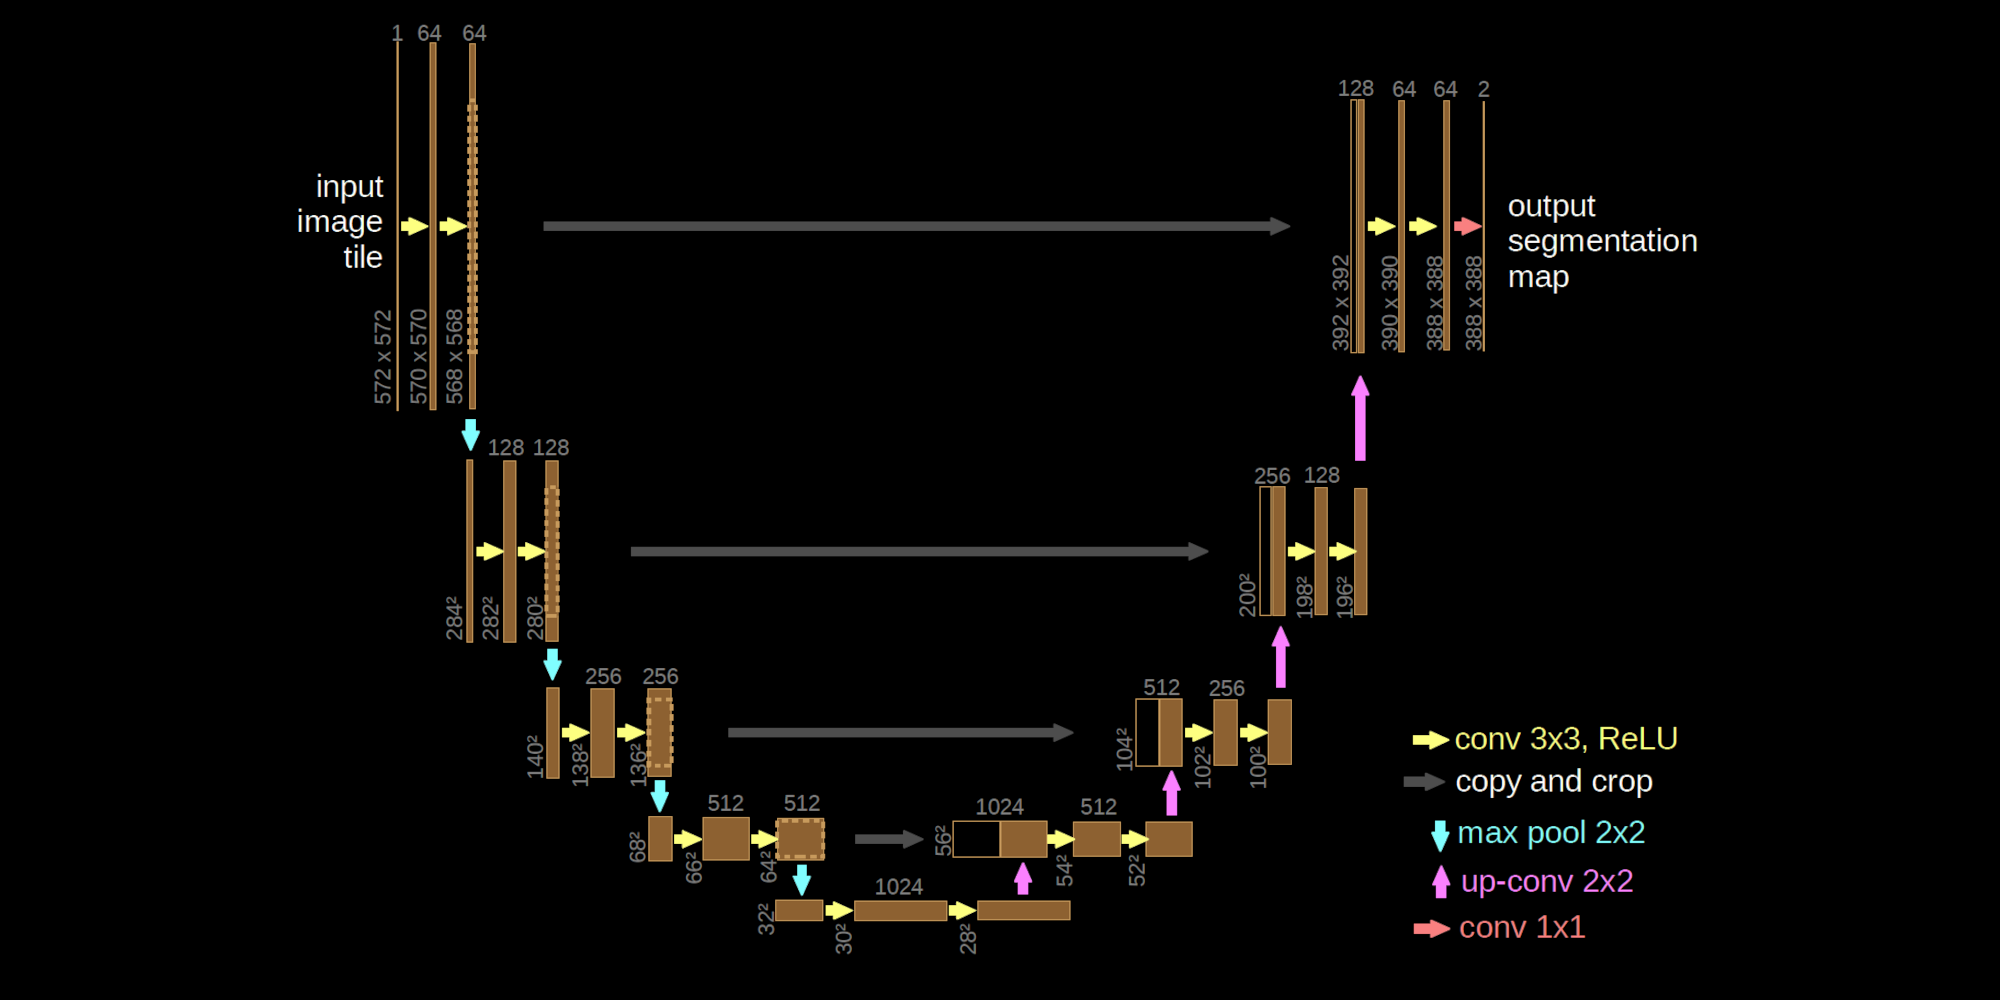

The concrete scenario will be forcing functions based on a discontinuity:

$$ f(x) = \begin{cases} 1 & \text{if } x \in [l_0, l_1] \\ 0 & \text{otherwise} \end{cases} $$

with $l_0 \propto \mathcal{U}(\frac{1}{5}L, \frac{2}{5}L)$ and $l_1 \propto \mathcal{U}( \frac{3}{5}L, \frac{4}{5}L)$.

We will draw 1'000 forcing functions and then discretize them on a grid of $32$
interior nodes. A reference solution is computed by a direct linear solver
applied to the three-point discretization.

With a 4:1 train/test split, the UNet is trained on MSE error on batch size of
32 for 100 epochs.

Modifications from the classical UNet:

* use linear convolution for downscaling instead of max pooling
* downscaling and upscaling are a 3x3 convolution with stride 2 (instead of 2x2)
* "same" padding to never have issues with spatial sizes
* no normalization layers for simplicity
* variable number levels (here we will use two)

In [2]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import equinox as eqx
from typing import Callable
import optax
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [4]:
plt.style.use("dark_background")

In [5]:
NUM_POINTS = 32
NUM_SAMPLES = 1000
DOMAIN_EXTENT = 5.0
# Grid excludes the two Dirichlet points
grid = jnp.linspace(0, DOMAIN_EXTENT, NUM_POINTS+2)[1:-1]
dx = grid[1] - grid[0]

A = jnp.diag(jnp.ones(NUM_POINTS-1), -1) - 2*jnp.diag(jnp.ones(NUM_POINTS), 0) + jnp.diag(jnp.ones(NUM_POINTS-1), 1)
A = A / dx**2

def solve_poisson(f):
    return jnp.linalg.solve(A, -f)

def create_discontinuity(key):
    limit_1_key, limit_2_key = jax.random.split(key)
    lower_limit = jax.random.uniform(limit_1_key, (), minval=0.2*DOMAIN_EXTENT, maxval=0.4*DOMAIN_EXTENT)
    upper_limit = jax.random.uniform(limit_2_key, (), minval=0.6*DOMAIN_EXTENT, maxval=0.8*DOMAIN_EXTENT)

    discontinuity = jnp.where((grid >= lower_limit) & (grid <= upper_limit), 1.0, 0.0)

    return discontinuity

primary_key = jax.random.PRNGKey(0)
keys = jax.random.split(primary_key, NUM_SAMPLES)
force_fields = jax.vmap(create_discontinuity)(keys)
displacement_fields = jax.vmap(solve_poisson)(force_fields)

# Add a singleton channel axis
displacement_fields = displacement_fields[:, None, :]
force_fields = force_fields[:, None, :]

In [6]:
force_fields.shape, displacement_fields.shape

((1000, 1, 32), (1000, 1, 32))

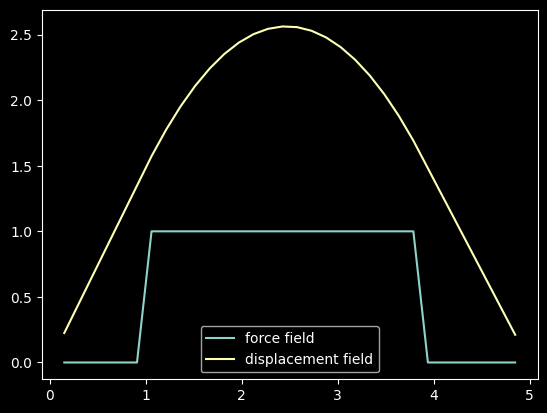

In [7]:
plt.plot(grid, force_fields[0, 0], label="force field")
plt.plot(grid, displacement_fields[0, 0], label="displacement field")
plt.legend()

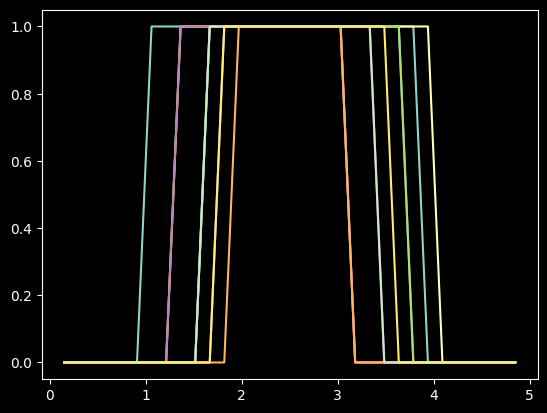

In [8]:
plt.plot(grid, force_fields[:10, 0].T);

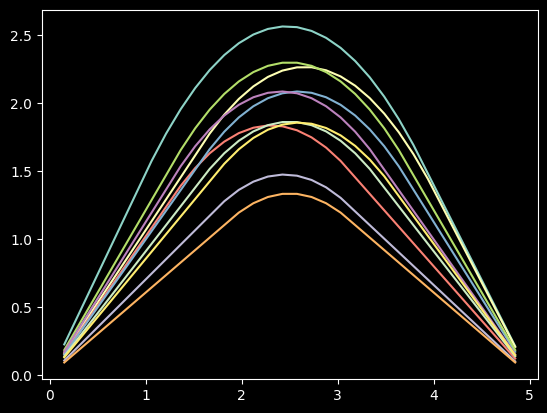

In [9]:
plt.plot(grid, displacement_fields[:10, 0].T);

In [10]:
# 4:1 train test split
split_index = NUM_SAMPLES // 5 * 4
train_x, test_x = force_fields[:split_index], force_fields[split_index:]
train_y, test_y = displacement_fields[:split_index], displacement_fields[split_index:]

In [11]:
train_x.shape, train_y.shape

((800, 1, 32), (800, 1, 32))

In [12]:
test_x.shape, test_y.shape

((200, 1, 32), (200, 1, 32))

In [13]:
class DoubleConv(eqx.Module):
    conv_1: eqx.nn.Conv
    conv_2: eqx.nn.Conv
    activation: Callable

    def __init__(
        self,
        num_spatial_dims: int,
        in_channels: int,
        out_channels: int,
        activation: Callable,
        *,
        key,
    ):
        c_1_key, c_2_key = jax.random.split(key)
        self.conv_1 = eqx.nn.Conv(
            num_spatial_dims,
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            key=c_1_key,
        )
        self.conv_2 = eqx.nn.Conv(
            num_spatial_dims,
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            key=c_2_key,
        )
        self.activation = activation
    
    def __call__(self, x: jax.Array):
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.conv_2(x)
        x = self.activation(x)
        return x

In [14]:
class UNet(eqx.Module):
    lifting: DoubleConv
    down_sampling_blocks: list[eqx.nn.Conv]
    left_arc_blocks: list[DoubleConv]
    right_arc_blocks: list[DoubleConv]
    up_sampling_blocks: list[eqx.nn.Conv]
    projection: eqx.nn.Conv

    def __init__(
        self,
        num_spatial_dims: int,
        in_channels: int,
        out_channels: int,
        hidden_channels: int,
        num_levels: int,
        activation: Callable,
        *,
        key,
    ):
        key, lifting_key, projection_key = jax.random.split(key, 3)
        self.lifting = DoubleConv(
            num_spatial_dims,
            in_channels,
            hidden_channels,
            activation,
            key=lifting_key,
        )
        self.projection = eqx.nn.Conv(
            num_spatial_dims,
            hidden_channels,
            out_channels,
            kernel_size=1,
            key=projection_key,
        )

        channel_list = [hidden_channels * 2**i for i in range(0, num_levels+1)]

        self.down_sampling_blocks = []
        self.left_arc_blocks = []
        self.right_arc_blocks = []
        self.up_sampling_blocks = []

        for (upper_level_channels, lower_level_channels) in zip(
            channel_list[:-1], channel_list[1:]
        ):
            key, down_key, left_key, right_key, up_key = jax.random.split(key, 5)

            self.down_sampling_blocks.append(
                eqx.nn.Conv(
                    num_spatial_dims,
                    upper_level_channels,
                    upper_level_channels,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    key=down_key,
                )
            )
            self.left_arc_blocks.append(
                DoubleConv(
                    num_spatial_dims,
                    upper_level_channels,
                    lower_level_channels,
                    activation,
                    key=left_key,
                )
            )
            self.right_arc_blocks.append(
                DoubleConv(
                    num_spatial_dims,
                    lower_level_channels,
                    upper_level_channels,
                    activation,
                    key=right_key,
                )
            )
            self.up_sampling_blocks.append(
                eqx.nn.ConvTranspose(
                    num_spatial_dims,
                    lower_level_channels,
                    upper_level_channels,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                    key=up_key,
                )
            )

    def __call__(self, x: jax.Array):
        x = self.lifting(x)
        x_skips = []

        # Left part of the arc
        for down, left in zip(self.down_sampling_blocks, self.left_arc_blocks):
            x_skips.append(x)
            x = down(x)
            x = left(x)
        
        # Right part of the arc
        for right, up in zip(reversed(self.right_arc_blocks), reversed(self.up_sampling_blocks)):
            x = up(x)
            # Equinox is without batch axis by default, hence channels are at axis 0
            x = jnp.concatenate([x, x_skips.pop()], axis=0)
            x = right(x)
        
        x = self.projection(x)

        return x

In [16]:
def count_parameters(model: eqx.Module):
    return sum(p.size for p in jtu.tree_leaves(eqx.filter(model, eqx.is_array)))

In [19]:
def dataloader(
    data,
    *,
    batch_size: int,
    key,
):
    """
    Loop generator over the data. The data can be a PyTree or an Array. For
    supervised learning problems you can also hand over a tuple of Arrays
    (=PyTree).
    """

    n_samples_list = [a.shape[0] for a in jtu.tree_leaves(data)]

    if not all(n == n_samples_list[0] for n in n_samples_list):
        raise ValueError(
            "All arrays / PyTree leaves must have the same number of samples. (Leading array axis)"
        )

    n_samples = n_samples_list[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        sub_data = jtu.tree_map(lambda a: a[batch_indices], data)

        yield sub_data

In [20]:
# Training loop

poisson_solver_unet = UNet(1, 1, 1, 32, 2, jax.nn.relu, key=jax.random.PRNGKey(0))

parameter_count = count_parameters(poisson_solver_unet)
print(parameter_count)

optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(poisson_solver_unet, eqx.is_array))

def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    mse = jnp.mean(jnp.square(y_pred - y))
    return mse

@eqx.filter_jit
def update_fn(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

loss_history = []
shuffle_key = jax.random.PRNGKey(151)
for epoch in tqdm(range(100)):
    shuffle_key, subkey = jax.random.split(shuffle_key)

    for batch in dataloader((train_x, train_y), batch_size=32, key=subkey):
        poisson_solver_unet, opt_state, loss = update_fn(
            poisson_solver_unet, opt_state, *batch,
        )
        loss_history.append(loss)


188353


  0%|          | 0/100 [00:00<?, ?it/s]

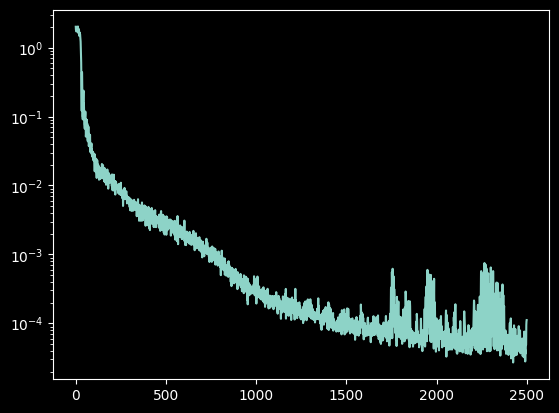

In [21]:
plt.semilogy(loss_history)

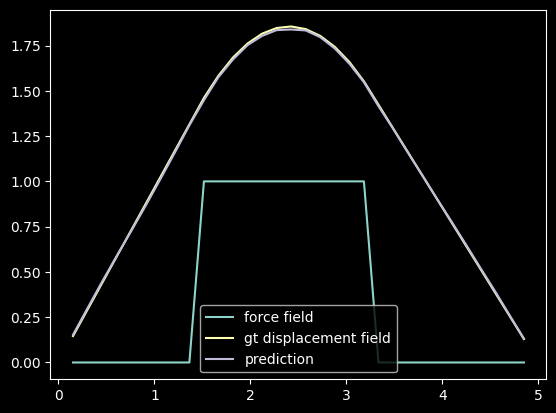

In [25]:
BATCH_I = 5
plt.plot(grid, test_x[BATCH_I, 0], label="force field")
plt.plot(grid, test_y[BATCH_I, 0], label="gt displacement field")
plt.plot(grid, poisson_solver_unet(test_x[BATCH_I])[0], label="prediction")
plt.legend()

In [26]:
def normalized_l2_norm(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

In [27]:
test_predictions = jax.vmap(poisson_solver_unet)(test_x)

In [28]:
test_errors = jax.vmap(normalized_l2_norm)(test_predictions, test_y)

In [29]:
test_errors.shape

(200,)

In [30]:
jnp.mean(test_errors), jnp.std(test_errors)

(Array(0.00631606, dtype=float32), Array(0.00108711, dtype=float32))